In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

import Data_Preprocessing.Graph_Data as gd
from Data_Preprocessing.Graph_Data import Molecule_data
from models.AttentiveFPModel import AttentiveFP

In [2]:
def createFoldsData():
    iy = 0
    folds = 5
    for fold in tqdm(range(folds)):
        df_train = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_train.csv')
        df_test  = pd.read_csv('New_fold/fold_'+str(iy)+'_'+'x_test.csv')
        smiles = df_train['SMILE']
        codIds = df_train['CODID']
        band_gap = df_train['bgs']
        band_gap = band_gap.to_numpy()

        smiles_test = df_test['SMILE']
        codIds_test = df_test['CODID']
        band_gap_test = df_test['bgs']
        band_gap_test = band_gap_test.to_numpy()


        smile_graph = {}
        band_gap_arr = []
        smiles_array = []

        for i,smile in enumerate(smiles):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph[smile] = g
                band_gap_arr.append(band_gap[i])
                smiles_array.append(smile)

        smile_graph_test = {}
        band_gap_arr_test = []
        smiles_array_test = []

        for i,smile in enumerate(smiles_test):
            g = gd.smile_to_graph(smile)
            if g != None:
                smile_graph_test[smile] = g
                band_gap_arr_test.append(band_gap_test[i])
                smiles_array_test.append(smile)

        train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(iy),y=band_gap_arr,
                                   smile_graph=smile_graph,smiles=smiles_array)

        test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(iy),y=band_gap_arr_test,
                                   smile_graph=smile_graph_test,smiles=smiles_array_test)

        iy+=1

In [3]:
df = pd.read_csv('Data_Preprocessing/omdb_smile_data_set.csv')

In [4]:
smiles = df['SMILE']
codIds = df['CODID']
band_gap = df['bgs']

In [5]:
band_gap = band_gap.to_numpy()

In [6]:
def createFoldsCsv():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5,shuffle = True, random_state = 42)
    ix = 0
    train1 = df
    for train_index, test_index in (kf.split(train1)):
        print ("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train,X_test=train1.iloc[train_index], train1.iloc[test_index]
        X_train.to_csv('New_fold/fold_'+str(ix)+'_'+'x_train.csv',index=False)
        X_test.to_csv('New_fold/fold_'+str(ix)+'_'+'x_test.csv',index=False)
        ix+=1
    createFoldsData()

In [7]:
processed_data_file_train = 'data/processed/' + 'test_data_set_fold_'+str(0)+'.pt'
processed_data_file_test = 'data/processed/'  + 'train_data_set_fold_'+str(0)+'.pt'
if ((not os.path.isfile(processed_data_file_train)) or (not os.path.isfile(processed_data_file_test))):
        print('please run create_data.py to prepare data in pytorch format!')
        createFoldsCsv()

In [8]:
if torch.cuda.is_available():  
    device = "cuda:4"
    print("cuda:4")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:4


In [9]:
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch,loss_fn):
    #print('Training on {} samples...'.format(len(train_loader1.dataset)))
    model.train()
    Loss = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index,data.batch)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        Loss.append(loss.item())
    nploss = np.asarray(Loss)
    avg_loss = np.average(nploss)
    return avg_loss

In [10]:
def predicting(model, device, loader,loss_fn):
    model.eval()
    total_loss=total_example=0
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data.x.float(), data.edge_index,data.batch)
            
            loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
            total_loss+=loss
            total_example+=1
    return total_loss/total_example

In [11]:
#LR = 0.005
LR = 9.797464088146652e-05
#LR = 0.0028894537419258915
LOG_INTERVAL = 20
NUM_EPOCHS = 3000
results = []

In [12]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [13]:
loss_fn = nn.L1Loss()

In [14]:
best_ret = []
best_mse = 0.80
best_ci = 0
best_epoch = -1

In [15]:
folds = 5
results = []
best_mae_arr = []

for fold in tqdm(range(folds)):
    val_losses = []
    train_losses = []
    mae_arr = []
    patience = 16
    trigger_times = 0
    the_last_loss = 100
    
    model_file_name = 'saved_models/model_' +  str(fold) +  '.model'
    result_file_name = 'result_' + str(fold) +  '.csv'
    
    train_data = Molecule_data(root='data', dataset='train_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    test_data = Molecule_data(root='data', dataset='test_data_set_fold_'+str(fold),y=None,smile_graph=None,smiles=None)
    
    TRAIN_BATCH_SIZE = 17
    
    train_loder   = DataLoader(train_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    test_loder  = DataLoader(test_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
    model = AttentiveFP(in_channels=114, hidden_channels=292, out_channels=1,
                    num_layers=3, num_timesteps=2,
                    dropout=0.047352327938708194).to(device)
    best_ret = []
    
    model = model.cuda(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    best_mae = 0.00
    
    for epoch in range(NUM_EPOCHS):
        train_loss=train(model, device, train_loder, optimizer, epoch+1,loss_fn)
        test_loss = predicting(model, device, test_loder,loss_fn)
        
        print('Epoch% d: Train mae: %2.5f\t val mae: %2.5f\t'
          %(epoch, train_loss,test_loss.item()))
        
        ret = [epoch,train_loss,test_loss.item()]
        
        train_losses.append(train_loss)
        val_losses.append(test_loss.item())
        
        # Early stopping
        the_current_loss = test_loss.item()
        
        best_ret.append(ret)
        
        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)
            
            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            ret = [epoch,train_loss,test_loss.item()]
            trigger_times = 0
            best_mae = the_current_loss
            the_last_loss = the_current_loss
            
            torch.save(model.state_dict(), model_file_name)

    results.append(best_ret)
    best_mae_arr.append(best_mae)

Epoch 0: Train mae: 0.88533	 val mae: 0.64400	
Epoch 1: Train mae: 0.60717	 val mae: 0.56342	
Epoch 2: Train mae: 0.55076	 val mae: 0.54148	
Epoch 3: Train mae: 0.51049	 val mae: 0.49833	
Epoch 4: Train mae: 0.47370	 val mae: 0.45337	
Epoch 5: Train mae: 0.45740	 val mae: 0.44023	
Epoch 6: Train mae: 0.44077	 val mae: 0.43629	
Epoch 7: Train mae: 0.42710	 val mae: 0.45495	
trigger times: 1
Epoch 8: Train mae: 0.41995	 val mae: 0.47643	
trigger times: 2
Epoch 9: Train mae: 0.41787	 val mae: 0.40537	
Epoch 10: Train mae: 0.41276	 val mae: 0.40820	
trigger times: 1
Epoch 11: Train mae: 0.40866	 val mae: 0.39724	
Epoch 12: Train mae: 0.39952	 val mae: 0.42772	
trigger times: 1
Epoch 13: Train mae: 0.39296	 val mae: 0.40266	
trigger times: 2
Epoch 14: Train mae: 0.39609	 val mae: 0.39451	
Epoch 15: Train mae: 0.38759	 val mae: 0.37951	
Epoch 16: Train mae: 0.38045	 val mae: 0.37308	
Epoch 17: Train mae: 0.37474	 val mae: 0.37821	
trigger times: 1
Epoch 18: Train mae: 0.37489	 val mae: 0.363

Epoch 19: Train mae: 0.35408	 val mae: 0.33751	
trigger times: 1
Epoch 20: Train mae: 0.34508	 val mae: 0.36866	
trigger times: 2
Epoch 21: Train mae: 0.34537	 val mae: 0.34718	
trigger times: 3
Epoch 22: Train mae: 0.34479	 val mae: 0.32712	
Epoch 23: Train mae: 0.34037	 val mae: 0.33004	
trigger times: 1
Epoch 24: Train mae: 0.33444	 val mae: 0.33813	
trigger times: 2
Epoch 25: Train mae: 0.33129	 val mae: 0.32695	
Epoch 26: Train mae: 0.33277	 val mae: 0.31965	
Epoch 27: Train mae: 0.32725	 val mae: 0.34256	
trigger times: 1
Epoch 28: Train mae: 0.32640	 val mae: 0.31241	
Epoch 29: Train mae: 0.32378	 val mae: 0.31193	
Epoch 30: Train mae: 0.31995	 val mae: 0.31033	
Epoch 31: Train mae: 0.32239	 val mae: 0.33340	
trigger times: 1
Epoch 32: Train mae: 0.31527	 val mae: 0.32964	
trigger times: 2
Epoch 33: Train mae: 0.31615	 val mae: 0.32137	
trigger times: 3
Epoch 34: Train mae: 0.31168	 val mae: 0.30266	
Epoch 35: Train mae: 0.30832	 val mae: 0.31435	
trigger times: 1
Epoch 36: Trai

Epoch 0: Train mae: 0.88440	 val mae: 0.69630	
Epoch 1: Train mae: 0.61194	 val mae: 0.55394	
Epoch 2: Train mae: 0.55426	 val mae: 0.49636	
Epoch 3: Train mae: 0.51606	 val mae: 0.45256	
Epoch 4: Train mae: 0.47808	 val mae: 0.44108	
Epoch 5: Train mae: 0.46370	 val mae: 0.41274	
Epoch 6: Train mae: 0.44805	 val mae: 0.40104	
Epoch 7: Train mae: 0.43501	 val mae: 0.40044	
Epoch 8: Train mae: 0.43036	 val mae: 0.40744	
trigger times: 1
Epoch 9: Train mae: 0.42187	 val mae: 0.38714	
Epoch 10: Train mae: 0.41458	 val mae: 0.37775	
Epoch 11: Train mae: 0.41281	 val mae: 0.36933	
Epoch 12: Train mae: 0.40702	 val mae: 0.37013	
trigger times: 1
Epoch 13: Train mae: 0.40021	 val mae: 0.39085	
trigger times: 2
Epoch 14: Train mae: 0.39329	 val mae: 0.35724	
Epoch 15: Train mae: 0.38650	 val mae: 0.38526	
trigger times: 1
Epoch 16: Train mae: 0.38444	 val mae: 0.35527	
Epoch 17: Train mae: 0.37928	 val mae: 0.37932	
trigger times: 1
Epoch 18: Train mae: 0.37219	 val mae: 0.33792	
Epoch 19: Tra

Epoch 138: Train mae: 0.20444	 val mae: 0.24919	
trigger times: 7
Epoch 139: Train mae: 0.20661	 val mae: 0.25403	
trigger times: 8
Epoch 140: Train mae: 0.19959	 val mae: 0.24233	
Epoch 141: Train mae: 0.19772	 val mae: 0.24380	
trigger times: 1
Epoch 142: Train mae: 0.19786	 val mae: 0.25546	
trigger times: 2
Epoch 143: Train mae: 0.19877	 val mae: 0.24781	
trigger times: 3
Epoch 144: Train mae: 0.20009	 val mae: 0.25425	
trigger times: 4
Epoch 145: Train mae: 0.19566	 val mae: 0.24775	
trigger times: 5
Epoch 146: Train mae: 0.19699	 val mae: 0.25016	
trigger times: 6
Epoch 147: Train mae: 0.19616	 val mae: 0.24719	
trigger times: 7
Epoch 148: Train mae: 0.19494	 val mae: 0.26312	
trigger times: 8
Epoch 149: Train mae: 0.19246	 val mae: 0.25514	
trigger times: 9
Epoch 150: Train mae: 0.19133	 val mae: 0.25341	
trigger times: 10
Epoch 151: Train mae: 0.19356	 val mae: 0.24740	
trigger times: 11
Epoch 152: Train mae: 0.19138	 val mae: 0.24401	
trigger times: 12
Epoch 153: Train mae: 0.

Epoch 102: Train mae: 0.23040	 val mae: 0.26645	
trigger times: 11
Epoch 103: Train mae: 0.22438	 val mae: 0.27056	
trigger times: 12
Epoch 104: Train mae: 0.22650	 val mae: 0.28696	
trigger times: 13
Epoch 105: Train mae: 0.22476	 val mae: 0.26374	
Epoch 106: Train mae: 0.22380	 val mae: 0.26419	
trigger times: 1
Epoch 107: Train mae: 0.22689	 val mae: 0.25997	
Epoch 108: Train mae: 0.22270	 val mae: 0.26000	
trigger times: 1
Epoch 109: Train mae: 0.22020	 val mae: 0.26107	
trigger times: 2
Epoch 110: Train mae: 0.21827	 val mae: 0.26434	
trigger times: 3
Epoch 111: Train mae: 0.21806	 val mae: 0.26688	
trigger times: 4
Epoch 112: Train mae: 0.21726	 val mae: 0.26127	
trigger times: 5
Epoch 113: Train mae: 0.21700	 val mae: 0.26562	
trigger times: 6
Epoch 114: Train mae: 0.21696	 val mae: 0.26675	
trigger times: 7
Epoch 115: Train mae: 0.21522	 val mae: 0.26352	
trigger times: 8
Epoch 116: Train mae: 0.21197	 val mae: 0.26247	
trigger times: 9
Epoch 117: Train mae: 0.21276	 val mae: 0

Epoch 64: Train mae: 0.26841	 val mae: 0.28298	
trigger times: 2
Epoch 65: Train mae: 0.26815	 val mae: 0.27917	
Epoch 66: Train mae: 0.26749	 val mae: 0.27904	
Epoch 67: Train mae: 0.26588	 val mae: 0.27773	
Epoch 68: Train mae: 0.26752	 val mae: 0.28152	
trigger times: 1
Epoch 69: Train mae: 0.26237	 val mae: 0.28578	
trigger times: 2
Epoch 70: Train mae: 0.25786	 val mae: 0.28277	
trigger times: 3
Epoch 71: Train mae: 0.26027	 val mae: 0.27727	
Epoch 72: Train mae: 0.25982	 val mae: 0.28458	
trigger times: 1
Epoch 73: Train mae: 0.25727	 val mae: 0.27706	
Epoch 74: Train mae: 0.25730	 val mae: 0.27902	
trigger times: 1
Epoch 75: Train mae: 0.25521	 val mae: 0.27721	
trigger times: 2
Epoch 76: Train mae: 0.25733	 val mae: 0.28587	
trigger times: 3
Epoch 77: Train mae: 0.25484	 val mae: 0.27754	
trigger times: 4
Epoch 78: Train mae: 0.25182	 val mae: 0.28797	
trigger times: 5
Epoch 79: Train mae: 0.25287	 val mae: 0.29262	
trigger times: 6
Epoch 80: Train mae: 0.24856	 val mae: 0.2760

In [16]:
format_float = "{:.2f}".format(best_mae)

In [17]:
type(format_float)

str

In [18]:
resSt = results[0][1]

In [19]:
res_val = resSt[2]

In [20]:
res_val

0.5634174942970276

121
121
152
152
170
170
173
173
175
175


/home/arslan/anaconda3/envs/band/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


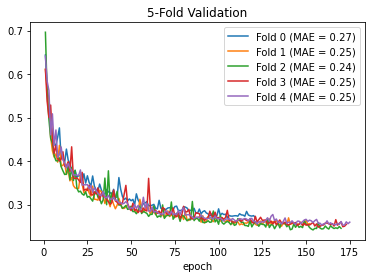

In [21]:
folds = 5
for fold in range(folds):
    train_loss_arr = []
    test_loss_arr = []
    for res in results[fold]:
        train_loss_arr.append(res[1])
        test_loss_arr.append(res[2])
        
    print(len(train_loss_arr))
    print(len(test_loss_arr))
    ax = plt.subplot(1,1,1)
    
    ax.WindowState = 'maximized';

    format_mae = "{:.2f}".format(best_mae_arr[fold])
    
  #  ax.plot([e for e in range(1,len(train_loss_arr) + 1)], train_loss_arr, label="train_loss")
    ax.plot([e for e in range(1,len(test_loss_arr) + 1)],
            test_loss_arr, label="Fold " + str(fold) + " (MAE = " + format_mae + ")")
    plt.xlabel("epoch")
    ax.title.set_text('5-Fold Validation')
    ax.legend()
    ax.figure.savefig('Visualization/'+str(fold)+'1.png')

In [22]:
train_loss_arr

[0.8441804415918509,
 0.5923182970370047,
 0.5474904919190533,
 0.491253633467711,
 0.46511226934786987,
 0.45340990748173327,
 0.43498349425517036,
 0.4257618988624209,
 0.42353547931201074,
 0.4182162104102709,
 0.40808697032759206,
 0.41209487459843347,
 0.4056205608963241,
 0.3985885847775496,
 0.39422973201555367,
 0.3908543557714497,
 0.38448218611384505,
 0.3775133316765934,
 0.3701670257181957,
 0.3687279938321568,
 0.3639321766536811,
 0.35656786539249924,
 0.3491506647265707,
 0.3536744139499161,
 0.3439427842112148,
 0.34605313441574453,
 0.34276840646900464,
 0.33900986385152015,
 0.33530927447953524,
 0.33629582245016193,
 0.3316237281773685,
 0.32586857845768724,
 0.326161172822813,
 0.3221761184701088,
 0.32010362936565406,
 0.3209369896512486,
 0.3156725556021046,
 0.31498816805848245,
 0.3129513729023643,
 0.31078828605265935,
 0.30782403290634464,
 0.30807536869153046,
 0.30617771884067546,
 0.3024873091229077,
 0.30234787678138236,
 0.3002346263514571,
 0.29785796274